In [ ]:
# from google.colab import drive
# drive.mount("./gdrive")

Mounted at ./gdrive


In [ ]:
!mkdir ./data
!cp -r "/content/gdrive/MyDrive/Colab Notebooks/ISR/ACRIMA" ./data/

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [ ]:
DATASET_PATH = "./data/ACRIMA"

train_dir = DATASET_PATH + "/train"
test_dir = DATASET_PATH + "/test"

def create_data_and_labels(path, label, data, labels):

    for img in os.listdir(path + "/" + label):
        image = cv2.imread(path + "/" + label + "/" + img, cv2.IMREAD_UNCHANGED)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (128,128))

        data.append(image)
        labels.append(label)
    return data, labels

X_train = []
y_train = []
X_train, y_train = create_data_and_labels(train_dir, "Non Glaucoma", X_train, y_train)
X_train, y_train = create_data_and_labels(train_dir, "Glaucoma", X_train, y_train)

X_test = []
y_test = []
X_test, y_test = create_data_and_labels(test_dir, "Non Glaucoma", X_test, y_test)
X_test, y_test = create_data_and_labels(test_dir, "Glaucoma", X_test, y_test)

In [ ]:
from sklearn.preprocessing import LabelEncoder

#normalization
X_train = np.array(X_train, dtype = "float") / 255
X_test = np.array(X_test, dtype = "float") / 255

y_train = np.array(y_train)
y_test = np.array(y_test)

#encoding labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (565, 128, 128, 3)
Shape of y_train:  (565,)
Shape of X_test:  (140, 128, 128, 3)
Shape of y_test:  (140,)


In [ ]:
input_shape = (128,128, 3)
num_classes = 2

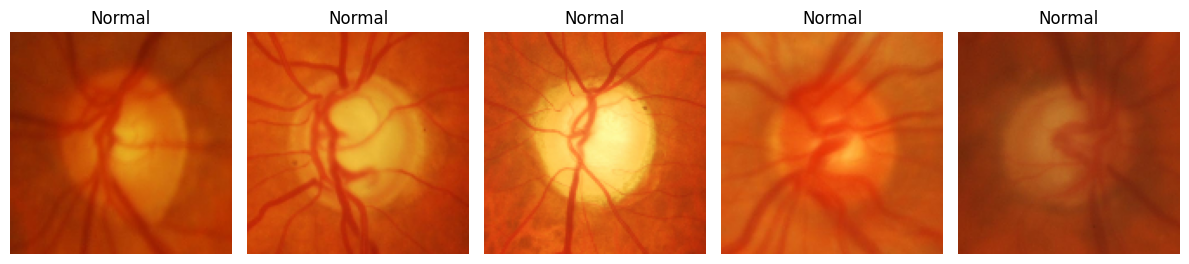

In [ ]:
num_samples = 5
random_indices = np.random.choice(X_train.shape[0], num_samples, replace=False)
samples = X_train[random_indices]
labels = y_train[random_indices]

fig, axs = plt.subplots(1, 5, tight_layout = True, figsize = (12,6), facecolor = 'white')
title = ["Normal", "Glaucoma"]

for i, ax in enumerate(axs.flat):
    ax.imshow(samples[i])
    ax.set_title(title[labels[i]])
    ax.axis('off')
plt.show()

In [ ]:
# data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow(
    X_train,
    y_train,
    batch_size=64
)

In [ ]:
steps_per_epoch = len(X_train) / train_generator.batch_size
total_images_seen = steps_per_epoch * train_generator.batch_size * 20 # 20 epochs

print("Total images seen during training:", total_images_seen)

Total images seen during training: 11300.0


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate(model,y_pred):
  # Calculate metrics
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)

  # Generate confusion matrix
  cm = confusion_matrix(y_test, y_pred)

  tn, fp, fn, tp = cm.ravel()
  specificity = tn / (tn + fp)

  # Print results
  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("F1 Score:", f1)
  print("Specificity:", specificity)
  print("Confusion Matrix:\n", cm)

def plot_performance(history):
  # Plot Loss
  plt.plot(history.history['loss'], label='train loss')
  plt.plot(history.history['val_loss'], label='val loss')
  plt.legend()
  plt.show()
  # Plot Accuracies
  plt.plot(history.history['accuracy'], label='train accuracy')
  plt.plot(history.history['val_accuracy'], label='val accurary')
  plt.legend()
  plt.show()

In [ ]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, Dropout, MaxPooling2D, Add, Dense, Flatten, Activation
from tensorflow.keras.optimizers import RMSprop, Adam

In [ ]:
# build the model
model = Sequential()

# input layer
model.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.6))
# output layer
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model.fit(train_generator,
                    epochs=20,
                    verbose=2,
                    validation_data=(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
9/9 - 8s - 838ms/step - accuracy: 0.6513 - loss: 0.6101 - val_accuracy: 0.8214 - val_loss: 0.4734
Epoch 2/20
9/9 - 3s - 363ms/step - accuracy: 0.7965 - loss: 0.4917 - val_accuracy: 0.8000 - val_loss: 0.4359
Epoch 3/20
9/9 - 4s - 438ms/step - accuracy: 0.8035 - loss: 0.4406 - val_accuracy: 0.8143 - val_loss: 0.3416
Epoch 4/20
9/9 - 2s - 233ms/step - accuracy: 0.8389 - loss: 0.3872 - val_accuracy: 0.8571 - val_loss: 0.2957
Epoch 5/20
9/9 - 2s - 236ms/step - accuracy: 0.8584 - loss: 0.3772 - val_accuracy: 0.8786 - val_loss: 0.2637
Epoch 6/20
9/9 - 2s - 232ms/step - accuracy: 0.8726 - loss: 0.3086 - val_accuracy: 0.9143 - val_loss: 0.2194
Epoch 7/20
9/9 - 4s - 396ms/step - accuracy: 0.8956 - loss: 0.2558 - val_accuracy: 0.9143 - val_loss: 0.2153
Epoch 8/20
9/9 - 2s - 233ms/step - accuracy: 0.9133 - loss: 0.2349 - val_accuracy: 0.9071 - val_loss: 0.1976
Epoch 9/20
9/9 - 2s - 235ms/step - accuracy: 0.9168 - loss: 0.2305 - val_accuracy: 0.9143 - val_loss: 0.2425
Epoch 10/20
9/9 - 2

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step
Accuracy: 0.9571428571428572
Precision: 0.9324324324324325
Recall: 0.9857142857142858
F1 Score: 0.9583333333333334
Specificity: 0.9285714285714286
Confusion Matrix:
 [[65  5]
 [ 1 69]]


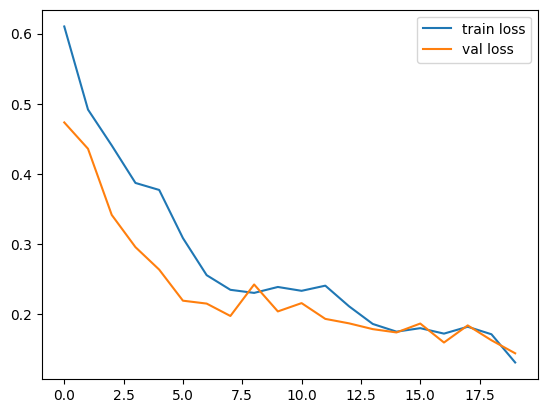

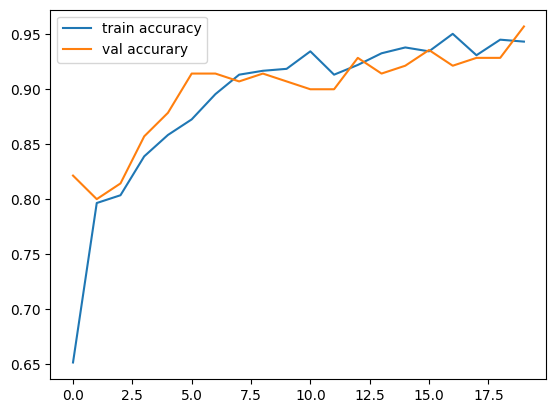

In [ ]:
# Make predictions
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to class labels (0 or 1)

evaluate(model,y_pred)
plot_performance(history)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


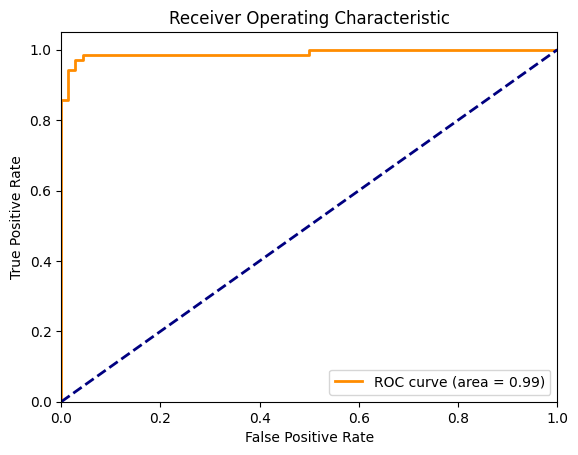

In [ ]:
from sklearn.metrics import roc_curve, auc
y_pred_proba = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
